##### Grading Feedback Cell
93%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# import statements

from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as fn
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml import feature
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT
from pyspark.ml import clustering
from pyspark.sql.functions import col

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

The following cell is used to determine if the environment is databricks or personal computer and determine the correct data file path accordingly.

In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Unsupervised learning

The colleges_data_science_programs dataset contains information about dozens of "data science" programs across the US.

## Question 1: (10 pts)

This dataset contains many columns that we can use to understand how these data science programs differ from one another.

## Question 1a (5 pts)
Using get_training_filename, read the colleges_data_science_programs.csv data file into a data frame named raw_ds_programs_text_df.  Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.

In [3]:
# Your code here

raw_ds_programs_text_df = spark.read.option("header","true").option("delimiter",",").option("inferSchema","true").csv('colleges_data_science_programs.csv')

raw_ds_programs_text_df.toPandas().head()

,id,name,url,program,degree,country,state,online,oncampus,department,...,cost,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,None,None
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,None,None
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,None,None
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,None,None
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,None,None


In [4]:
print('Shape = ',(raw_ds_programs_text_df.count(), len(raw_ds_programs_text_df.columns)))

Shape =  (222, 28)


In [5]:
raw_ds_programs_text_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- url: string (nullable = true)
 |-- program: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- online: boolean (nullable = true)
 |-- oncampus: boolean (nullable = true)
 |-- department: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- university_count: integer (nullable = true)
 |-- program_size: string (nullable = true)
 |-- courses: string (nullable = true)
 |-- admit_reqs: string (nullable = true)
 |-- year_founded: integer (nullable = true)
 |-- notes: string (nullable = true)
 |-- cost: string (nullable = true)
 |-- visualization: string (nullable = true)
 |-- machine learning: string (nullable = true)
 |-- business: string (nullable = true)
 |-- databases: string (nullable = true)
 |-- programminglanguages: string (nullable = true)
 |-- capston

In [6]:
from pyspark.sql.functions import isnan, isnull, when, count, col

raw_ds_programs_text_df.select([count(when(isnull(c), c)).alias(c) for c in raw_ds_programs_text_df.columns]).show()

+---+----+---+-------+------+-------+-----+------+--------+----------+----------+----------+----------------+------------+-------+----------+------------+-----+----+-------------+----------------+--------+---------+--------------------+--------+---------+---------+------+
| id|name|url|program|degree|country|state|online|oncampus|department|created_at|updated_at|university_count|program_size|courses|admit_reqs|year_founded|notes|cost|visualization|machine learning|business|databases|programminglanguages|capstone|mapreduce|part-time|ethics|
+---+----+---+-------+------+-------+-----+------+--------+----------+----------+----------+----------------+------------+-------+----------+------------+-----+----+-------------+----------------+--------+---------+--------------------+--------+---------+---------+------+
|  0|   0|  1|      0|     0|      0|   98|     0|       0|        90|         3|         3|               0|         213|    201|       204|         213|  217| 215|          221|  

##### Grading Feedback Cell

## Question 1b (5 pts)
Starting with `raw_ds_programs_text_df`, create a new dataframe named`ds_programs_text_df` which simply adds a column `text` to the dataframe `raw_ds_programs_df`. This column will have the concatenation of the following columns separated by a space: `program`, `degree` and `department` (find the appropriate function in the `fn` package). <br>

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text_df.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```
<br>
- Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.<br>
- Print the text column in the first row of the ds_programs_text_df.

In [7]:
# Your code here

ds_programs_text_df = raw_ds_programs_text_df.withColumn("text",fn.concat_ws("",fn.col('program'),fn.lit(' '),fn.col('degree'),fn.lit(' '),fn.col('department')))

print('Text column in the first row :',ds_programs_text_df.orderBy('id').first().text)

Text column in the first row : Data Science Masters Mathematics and Statistics


In [8]:
ds_programs_text_df.toPandas().head()

,id,name,url,program,degree,country,state,online,oncampus,department,...,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Sys...
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,None,Data Science Masters Computer Science
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,None,Business Intelligence & Analytics Masters Busi...
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,None,Advanced Computer Science(Data Analytics) Mast...


In [9]:
print('Shape = ',(ds_programs_text_df.count(), len(ds_programs_text_df.columns)))

Shape =  (222, 29)


In [10]:
(ds_programs_text_df.groupBy('text').count().orderBy('count',ascending=False)).show()

+--------------------+-----+
|                text|count|
+--------------------+-----+
|Business Analytic...|   20|
|Data Science Mast...|    8|
|Business Analytic...|    7|
|Business Intellig...|    4|
|Data Analytics Ma...|    3|
|Data Science Mast...|    3|
|Data Science Mast...|    3|
|Machine Learning ...|    3|
|Data Science Bach...|    3|
|Big Data Analytic...|    2|
|Business Informat...|    2|
|Business Data Ana...|    2|
|Applied Statistic...|    2|
|Machine Learning ...|    2|
|Marketing Analyti...|    2|
|Data Analytics Ma...|    2|
|Analytics Masters...|    2|
|Data Mining And K...|    2|
|Information Engin...|    2|
|Business Analytic...|    2|
+--------------------+-----+
only showing top 20 rows



##### Grading Feedback Cell

# Question 2: (10 pts) 

## Question 2a (5 pts)
Create a pipeline named `pipe_features` that creates a new dataframe `ds_features_df`.  The pipe_features pipeline adds a column `features` to `ds_programs_text_df` that contains the `tfidf` of the `text` column.  Print the head of ds_features_df using Pandas and print the shape using spark.

In [11]:
# Create ds_programs_text_df here

tokenizer = feature.RegexTokenizer()\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = feature.CountVectorizer(inputCol='filtered', outputCol='tf')
idf = feature.IDF(inputCol='tf', outputCol='features')

pipe_features = Pipeline(stages=[tokenizer, sw_filter, cv, idf]).fit(ds_programs_text_df)


ds_features_df = pipe_features.transform(ds_programs_text_df)

ds_features_df = ds_features_df.select([c for c in ds_features_df.columns if c not in {'words', 'filtered', 'tf'}])

ds_features_df.toPandas().head()

,id,name,url,program,degree,country,state,online,oncampus,department,...,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text,features
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics,"(0.2538801769623398, 0.6622396430968687, 0.0, ..."
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Sys...,"(0.2538801769623398, 0.0, 1.0377239189930973, ..."
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,Data Science Masters Computer Science,"(0.2538801769623398, 0.6622396430968687, 0.0, ..."
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,Business Intelligence & Analytics Masters Busi...,"(0.2538801769623398, 0.0, 2.0754478379861947, ..."
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,Advanced Computer Science(Data Analytics) Mast...,"(0.2538801769623398, 0.6622396430968687, 0.0, ..."


In [12]:
print('Shape = ',(ds_features_df.count(), len(ds_features_df.columns)))

Shape =  (222, 30)


##### Grading Feedback Cell

## Question 2b (5 pts)
Create a pipeline model `pipe_pca` that computes the two first principal components of the `features` column as computed by `pipe_features` and creates a column named `scores`. Use that pipeline to create a dataframe `ds_features_df` with the columns `id`, `name`, `url`, and `scores`.

In [13]:
# create ds_features_df here


In [14]:
norm = feature.Normalizer(inputCol="features", outputCol="norm_features", p=2.0)

In [15]:
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='norm_features', outputCol='centered_features')

In [16]:
pca = feature.PCA(k=2, inputCol='centered_features', outputCol='scores')

In [17]:
pipe = Pipeline(stages=[pipe_features,norm, center, pca])

In [18]:
pipe_pca = pipe.fit(ds_programs_text_df)

In [19]:
ds_features_df = pipe_pca.transform(ds_programs_text_df).select("id","name","url","scores")

In [20]:
ds_features_df.show()

+---+--------------------+--------------------+--------------------+
| id|                name|                 url|              scores|
+---+--------------------+--------------------+--------------------+
|  1|South Dakota Stat...|http://www.sdstat...|[0.29857900149242...|
|  2|Dakota State Univ...|http://www.dsu.ed...|[-0.1534520333238...|
|  3|    Lewis University|http://www.lewisu...|[0.53462992779113...|
|  4|Saint Joseph's Un...|http://online.sju...|[-0.5567222515050...|
|  5| University Of Leeds|http://www.engine...|[0.28693865130819...|
|  6|Arizona State Uni...|http://wpcarey.as...|[-0.4171925272139...|
|  7|University Of Cen...|http://dms.stat.u...|[0.23472600211371...|
|  8|Hong Kong Univers...|http://www.rmbi.u...|[-0.0601249292894...|
|  9|University of Tex...|https://jindal.ut...|[-0.3168984458584...|
| 10|The Ohio State Un...|https://data-anal...|[0.10358154563647...|
| 11|University of Roc...|http://www.roches...|[0.28899719318425...|
| 12|         TU Dortmund|http://w

##### Grading Feedback Cell

# Question 3: (10 pts)

Create a scatter plot with the x axis containing the first principal component (loading) and the y axis containing the second principal component (loading) of `ds_features_df`

In [21]:
# Your code here

PC1 = pipe_pca.stages[-1].pc.toArray()[:, 0]
PC2 = pipe_pca.stages[-1].pc.toArray()[:, 1]


Text(0.5, 1.0, 'Scatter Plot of 1st vs 2nd Principal Component')

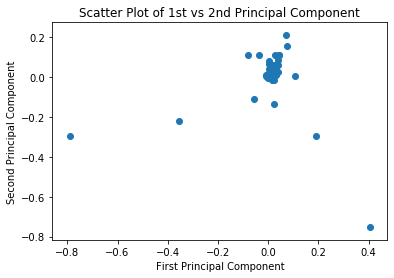

In [22]:

fig, ax = plt.subplots()
ax.scatter(PC1, PC2)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Scatter Plot of 1st vs 2nd Principal Component")

##### Grading Feedback Cell
-1: Incorrect title - should be 2nd vs. first

# Question 4 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `word` and `abs_loading` that contain the top 5 words and absolute loadings for the principal components 1 and 2, respetively.  Print both dataframes. Interpret the loadings.

In [23]:
vocabulary = pipe_features.stages[2].vocabulary

pc1 = pipe_pca.stages[-1].pc.toArray()[:, 0].tolist()
pc2 = pipe_pca.stages[-1].pc.toArray()[:, 1].tolist()

In [24]:
# your code here (5 pts)

pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                     1: 'load_pc1',
                                                                     2: 'load_pc2'})

In [25]:
pc1_pd = pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).head(5)

pc1_pd.rename(columns = {'load_pc1':'abs_loading'}, inplace = True) 

In [26]:
pc1_pd

,word,abs_loading
2,business,0.789584
3,analytics,0.356161
8,intelligence,0.079404
0,masters,0.0571936
12,management,0.0369485


In [27]:
pc2_pd = pc_loadings.sort_values('load_pc2').\
    apply({'word': lambda x: x, 'load_pc2': np.abs}, axis=0).head(5)

pc2_pd.rename(columns = {'load_pc2':'abs_loading'}, inplace = True) 

In [28]:
pc2_pd

,word,abs_loading
4,science,0.752678
2,business,0.297165
1,data,0.29447
3,analytics,0.221209
9,bachelors,0.1365


In [29]:
pc2_loadings = pc_loadings.\
    apply({'word': lambda x: x, 'load_pc1': np.abs,'load_pc2': np.abs}, axis=0)

In [30]:
pd.set_option('display.max_rows', None)

pc2_loadings


,word,load_pc1,load_pc2
0,masters,0.0571936,0.109802
1,data,0.188804,0.29447
2,business,0.789584,0.297165
3,analytics,0.356161,0.221209
4,science,0.404951,0.752678
5,mining,0.0696768,0.210747
6,statistics,0.0735945,0.156344
7,information,0.0288079,0.110432
8,intelligence,0.079404,0.108113
9,bachelors,0.0253734,0.1365


##### Grading Feedback Cell
-1: Need to take absolute value and then sort.  You sorted and then took the absolute value.  The sign only indicates direction and does not affect the imprtance.

Your interpretation here (5 pts): The loading vectors captures the specific direction for the principal components which captures the variance. Loading vector for words such as business, analytics,computational, engineering have the highest effect for the 1st Principal component while words such as informatics, science, intelligence, artificial, algorithms have the highest effect for the 2nd Principal Component rather than 1st Principal Component meaning these are more important in the 2nd component. For 1st PC words such as business, analytics,computational, engineering are most important and for 2nd PC words such as informatics, science, intelligence, artificial, algorithms are the most important. Higher the magnitude is of loading vector that loading vector points to the direction of maximum variance for that word.

##### Grading Feedback Cell
The loading vector coefficients represent covariance between the words and the loading vector if withStd=False in the standard scaler.  If withStd=True, the loading vector coefficients would represent correlation between the words and the loading vector.

# Question 5: (10 pts)

Create a new pipeline for PCA called `pipe_pca2` where you fit 50 principal components. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable named `explainedVariance` which represents the variance explained by components of the model. Finally, assign to a variable named `best_k` the value $k$ such that ($k+1$)-th component is not able to explain more than 0.01 variance. You can use a for-loop to find such best k.  The value best_k should be be 0 based - in other words present best_k assuming that you started counting at 0.

In [31]:
# your code here

pca_2 = feature.PCA(k=50, inputCol='centered_features', outputCol='scores')

In [32]:
pipe_2 = Pipeline(stages=[pipe_features, norm, center, pca_2])

In [33]:
pipe_pca2 = pipe_2.fit(ds_programs_text_df)

In [34]:
explainedVariance = pipe_pca2.stages[-1].explainedVariance

In [35]:
pipe_pca2.stages[-1].explainedVariance

DenseVector([0.1485, 0.0858, 0.051, 0.0471, 0.0425, 0.0406, 0.0379, 0.0372, 0.0359, 0.0319, 0.029, 0.0238, 0.0228, 0.0204, 0.0181, 0.0163, 0.0159, 0.014, 0.0137, 0.0126, 0.0116, 0.0114, 0.011, 0.0107, 0.0099, 0.0098, 0.0092, 0.0091, 0.008, 0.0075, 0.0073, 0.0069, 0.0066, 0.0064, 0.0061, 0.0061, 0.0056, 0.0053, 0.005, 0.0049, 0.0046, 0.0045, 0.0043, 0.0041, 0.004, 0.0039, 0.0038, 0.0037, 0.0036, 0.0035])

In [36]:

k=0
for item in explainedVariance:
    if item>0.01:
        k+=1
best_k = k

print('best_k is' ,best_k)
print('Number of components that can explain more than 0.01 variance is',best_k)

best_k is 24
Number of components that can explain more than 0.01 variance is 24


##### Grading Feedback Cell
-1: You really should not be using a normalizer here.  The normalizer is only useful for visualization.

# Question 6: (10 pts)

Create a new pipeline for PCA called pipe_pca3 (similar to pipe_pca2 above) where you fit the maximum possible number of principal components for this dataset. Create a scree plot and a plot of cumulative variance explained.

In [37]:
# your code here

pca_3 = feature.PCA(k=len(pipe_features.stages[2].vocabulary), inputCol='centered_features', outputCol='scores')

pipe_3 = Pipeline(stages=[pipe_features, norm, center, pca_3])

In [38]:
pipe_pca3=pipe_3.fit(ds_programs_text_df)

In [39]:
pipe_pca3.stages[-1].explainedVariance

DenseVector([0.1485, 0.0858, 0.051, 0.0471, 0.0425, 0.0406, 0.0379, 0.0372, 0.0359, 0.0319, 0.029, 0.0238, 0.0228, 0.0204, 0.0181, 0.0163, 0.0159, 0.014, 0.0137, 0.0126, 0.0116, 0.0114, 0.011, 0.0107, 0.0099, 0.0098, 0.0092, 0.0091, 0.008, 0.0075, 0.0073, 0.0069, 0.0066, 0.0064, 0.0061, 0.0061, 0.0056, 0.0053, 0.005, 0.0049, 0.0046, 0.0045, 0.0043, 0.0041, 0.004, 0.0039, 0.0038, 0.0037, 0.0036, 0.0035, 0.0034, 0.0032, 0.0031, 0.0031, 0.003, 0.0029, 0.0029, 0.0028, 0.0026, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023, 0.0022, 0.002, 0.0019, 0.0018, 0.0018, 0.0015, 0.0015, 0.0013, 0.001, 0.0008, 0.0007, 0.0005, 0.0003, 0.0003, 0.0002, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Text(0, 0.5, 'Proportion Variance Explained')

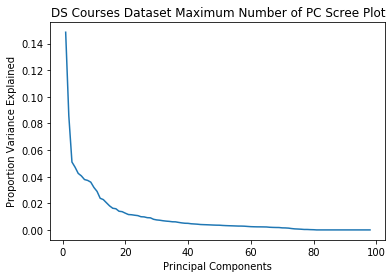

In [40]:
plt.figure()
explained_var_pipe1 = pipe_pca3.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var_pipe1)+1), explained_var_pipe1)
plt.title("DS Courses Dataset Maximum Number of PC Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

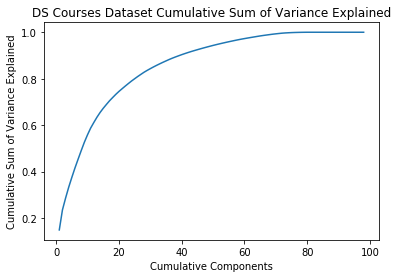

In [41]:
cum_sum = np.cumsum(explained_var_pipe1)
plt.figure()
plt.plot(np.arange(1, len(explained_var_pipe1)+1), cum_sum)
plt.title("DS Courses Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

##### Grading Feedback Cell
-1 The normalizer is not needed here because the visualization does not plot scores or loadings directly

# Question 7: (10 pts)
Create a pipeline named pipe_pca4 (similar to pipe_pca3 above) that computes the first 2 principal components.  Add a kmeans objects to the end of pipe_pca4 and compute kmeans with k = 5.  Create a scatter plot PC2 vs. PC1 where each scatter dot is colored by the cluster assignment.  Include a plot legend.

In [42]:
# your code here


In [43]:
kmeans = clustering.KMeans(k=5, featuresCol='scores', predictionCol='kmeans_feat')

In [44]:
pipe_4 = Pipeline(stages=[tokenizer, sw_filter, cv, idf, norm, center, pca, kmeans])

In [45]:
pipe_pca4 = pipe_4.fit(ds_programs_text_df)

In [46]:
cluster=pipe_pca4.transform(ds_programs_text_df)

cluster.select('kmeans_feat','text')

DataFrame[kmeans_feat: int, text: string]

In [47]:
program_names = np.array(ds_programs_text_df.select('text').rdd.map(lambda x: x['text']).collect())
X = np.array(pipe_pca4.transform(ds_programs_text_df).select('scores').rdd.map(lambda x: x['scores']).collect())
print("X.shape:", X.shape)

X.shape: (222, 2)


In [48]:
cluster_list = cluster.select(col("kmeans_feat")).collect()

In [49]:
cluster_assign = [int(row.kmeans_feat) for row in cluster_list]

cluster_assign

[0,
 4,
 3,
 1,
 0,
 1,
 2,
 4,
 4,
 0,
 0,
 2,
 0,
 2,
 2,
 3,
 1,
 0,
 3,
 2,
 4,
 0,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 4,
 2,
 4,
 2,
 0,
 4,
 1,
 0,
 2,
 2,
 0,
 2,
 4,
 2,
 0,
 2,
 1,
 4,
 4,
 4,
 4,
 1,
 3,
 0,
 2,
 2,
 1,
 0,
 3,
 0,
 3,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 3,
 3,
 0,
 0,
 2,
 1,
 2,
 4,
 1,
 4,
 2,
 2,
 2,
 1,
 2,
 0,
 4,
 2,
 4,
 3,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 3,
 4,
 1,
 4,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 4,
 2,
 4,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 3,
 2,
 1,
 2,
 2,
 4,
 4,
 1,
 1,
 1,
 1,
 4,
 2,
 2,
 0,
 4,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 4,
 1,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 4,
 3,
 1,
 1,
 1,
 4,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 4,
 2,
 2,
 1,
 2,
 3,
 0,
 0,
 0,
 3,
 2,
 3,
 2,
 2,
 2,
 1,
 0,
 0,
 4,
 1,
 2,
 0,
 4,
 3,
 3,
 0,
 0,
 3,
 3,
 2,
 0,
 2,
 3,
 3,
 4,
 4,
 0,
 0,
 3]

In [50]:
LABEL_COLOR_MAP = {label:idx for idx,label in enumerate(np.unique(cluster_assign))}

In [51]:
labels = np.unique(cluster_assign)

In [52]:
label_color = [LABEL_COLOR_MAP[l] for l in cluster_assign]

In [53]:


pc1_pca4 = X[:,0]
pc2_pca4 = X[:,1]

In [54]:

pc_loadings_pc4 = pd.DataFrame([cluster_assign, pc1_pca4, pc2_pca4]).T.rename(columns={0: 'cluster', 
                                                                     1: 'load_pc1_pca4',
                                                                     2: 'load_pc2_pca4'})

In [55]:
pc_loadings_pc4

,cluster,load_pc1_pca4,load_pc2_pca4
0,0.0,0.298579,0.033423
1,4.0,-0.153452,0.165000
2,3.0,0.534630,-0.632946
3,1.0,-0.556722,-0.001667
4,0.0,0.286939,-0.305452
5,1.0,-0.417193,-0.217917
6,2.0,0.234726,0.362022
7,4.0,-0.060125,0.165008
8,4.0,-0.316898,0.095211
9,0.0,0.103582,0.017592


[Text(0, 0.5, 'PC2'),
 Text(0.5, 0, 'PC1'),
 Text(0.5, 1.0, 'Scatter Plot of PC1 vs PC2 Cluster Assignment Kmeans')]

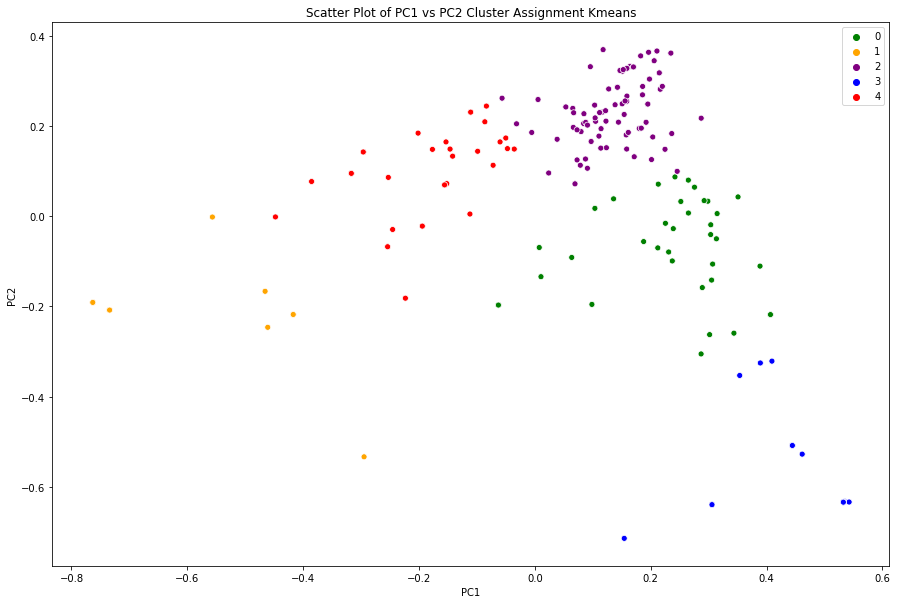

In [56]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=pc1_pca4,y=pc2_pca4,hue=label_color,legend='full',data=pc_loadings_pc4,palette=['green','orange','purple','blue','red'])


ax.set(xlabel='PC1', ylabel='PC2', title='Scatter Plot of PC1 vs PC2 Cluster Assignment Kmeans')

[Text(0, 0.5, 'PC2'),
 Text(0.5, 0, 'PC1'),
 Text(0.5, 1.0, 'Scatter Plot of PC1 vs PC2 Cluster Assignment Kmeans')]

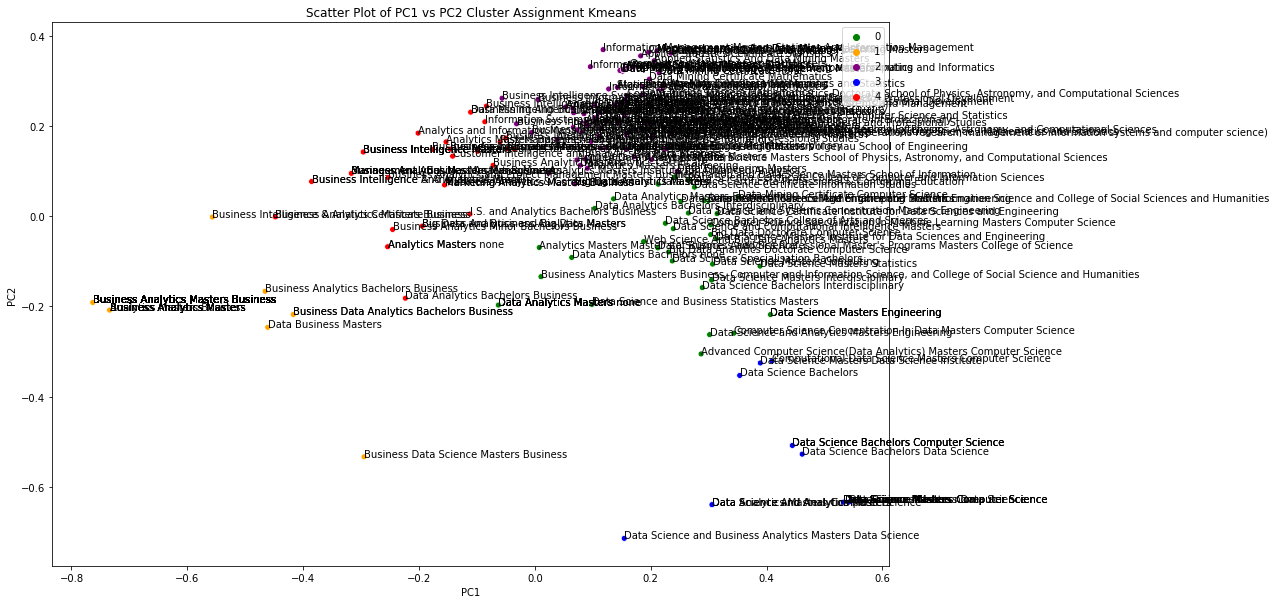

In [57]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=pc1_pca4,y=pc2_pca4,hue=label_color,legend='full',data=pc_loadings_pc4,palette=['green','orange','purple','blue','red'])

for i, txt in enumerate(program_names):
    ax.annotate(txt, (X[i,0], X[i,1]))
ax.set(xlabel='PC1', ylabel='PC2', title='Scatter Plot of PC1 vs PC2 Cluster Assignment Kmeans')

##### Grading Feedback Cell
-1: Incorrect title - should be pc2 vs pc1

# Question 8: (10 pts)
Starting with pipe_pca2, transform the pipeline and save the resulting dataframe to a variable named `pca_fun`.  Extract the output from the standard scaler column from the first row of pca_fun and store in a variable called `z`. Manually compute 10 PCA scores by projecting z onto the first 10 loading vectors. Save the 10 projected pca scores in a varialbe called `projection`.  Extract the first 10 PCA scores from the first row of pca_fun and save them in a variable named `model_scores`.  Print `projection` and `model_scores`.  Compare `projection` to `model_scores` and explain why they are the same or different. 

In [58]:
# your code here (5 pts)

pca_fun = pipe_pca2.transform(ds_programs_text_df)

In [59]:
pca_fun

DataFrame[id: int, name: string, url: string, program: string, degree: string, country: string, state: string, online: boolean, oncampus: boolean, department: string, created_at: string, updated_at: string, university_count: int, program_size: string, courses: string, admit_reqs: string, year_founded: int, notes: string, cost: string, visualization: string, machine learning: string, business: string, databases: string, programminglanguages: string, capstone: string, mapreduce: string, part-time: string, ethics: string, text: string, words: array<string>, filtered: array<string>, tf: vector, features: vector, norm_features: vector, centered_features: vector, scores: vector]

In [60]:
z = pca_fun.select("centered_features").first()["centered_features"]

print(z)

[-0.013960987479426569,0.02903977922145093,-0.1869066926797856,-0.1418105425210323,0.14267188991502733,-0.055779278983693774,0.4726609864737805,-0.04158317669336304,-0.05520396918004868,-0.050992378232792616,-0.03742288195598016,-0.053066752529210795,-0.04373824081395738,-0.041722665817657094,-0.025300371484256953,-0.027928478882196326,-0.028009841222531386,-0.028009841222531386,-0.022062962788122396,-0.02583922151008636,-0.02373749142436795,-0.022767297456519866,-0.01732534091997008,-0.02064495409077225,-0.015575937141142839,-0.012796619740307356,-0.016181814565732023,-0.011907002630526712,-0.016290231055895558,0.7734771856103444,-0.015516506135481334,-0.009289332729244195,-0.011965572723337047,-0.01229875584740118,-0.008613284977597795,-0.004991692559764474,-0.004991692559764474,-0.008879795876566425,-0.007051104639743689,-0.0049681666790416384,-0.0070517215322778585,-0.007748599357599836,-0.0042332938106349124,-0.005244499301901333,-0.005067979988130264,-0.004800150359983702,-0.0086

In [61]:
loadings = pipe_pca2.stages[-1].pc.toArray()

In [62]:
z[:10]

array([-0.01396099,  0.02903978, -0.18690669, -0.14181054,  0.14267189,
       -0.05577928,  0.47266099, -0.04158318, -0.05520397, -0.05099238])

In [63]:
projection = z[:].dot(loadings[:,:10])

projection

array([ 0.298579  ,  0.03342339,  0.24046827,  0.26106807, -0.04398082,
       -0.2893498 , -0.04025039,  0.24308755,  0.02072018, -0.07967021])

In [64]:
model_scores = pca_fun.select("scores").first()["scores"][:10]

model_scores

array([ 0.298579  ,  0.03342339,  0.24046827,  0.26106807, -0.04398082,
       -0.2893498 , -0.04025039,  0.24308755,  0.02072018, -0.07967021])

##### Grading Feedback Cell

Your explanation here (5 pts): The projection scores(PCA scores manually calculated) and the PCA scores are almost the same because the multiplication of loading vectors with the observation gives the z scores. The Projection is same as linear combination of loading vectors and the input produced by multiplying data observations with loading vectors. The z scores are same as the method to calculate the scores for PCA for each row is exactly the same as projecting the data observations onto the loading vectors to get score for each row.

##### Grading Feedback Cell

# Question 9: (10 pts)
Using PCA loading vectors, perform an inverse transform on the `projection` variable and store the result in a variable named inverse.  Print `inverse` and the original `z` data.  Explain why the inverse data is the same as `z` (or really close to `z`), or why it is different than `z`.  

In [65]:
# your code here (5 pts)

np.set_printoptions(suppress=True)

inverse = loadings[:,:10].dot(projection[:])

inverse

array([-0.01054586,  0.03082886, -0.1973422 , -0.12129482,  0.14662014,
        0.02237293,  0.49229299, -0.03169049, -0.05844035, -0.05407065,
        0.03130743, -0.06307056, -0.07260337, -0.06142588, -0.02155038,
       -0.00370395, -0.04355452, -0.04355452,  0.00556817, -0.00294848,
       -0.0231779 ,  0.00063769, -0.0123476 , -0.0132568 , -0.00464937,
       -0.00277107,  0.02821954, -0.00070637, -0.03407812,  0.0568441 ,
        0.13410896, -0.00304443, -0.00690803, -0.00212136, -0.00497995,
       -0.00199599, -0.00199599,  0.00031891, -0.00144632, -0.00122064,
        0.00165002, -0.00049709, -0.00101003,  0.00035523, -0.00304054,
        0.00663695, -0.00409269, -0.00638025, -0.0008564 ,  0.000388  ,
       -0.00270444,  0.00019157, -0.0034846 , -0.0008564 , -0.00141732,
       -0.00494209, -0.0020906 , -0.00020497,  0.00121918, -0.0005834 ,
       -0.00070866, -0.00043257, -0.00090495, -0.00090495, -0.00020497,
       -0.0071758 , -0.00310582, -0.00094245, -0.00050442, -0.00

In [66]:
z

DenseVector([-0.014, 0.029, -0.1869, -0.1418, 0.1427, -0.0558, 0.4727, -0.0416, -0.0552, -0.051, -0.0374, -0.0531, -0.0437, -0.0417, -0.0253, -0.0279, -0.028, -0.028, -0.0221, -0.0258, -0.0237, -0.0228, -0.0173, -0.0206, -0.0156, -0.0128, -0.0162, -0.0119, -0.0163, 0.7735, -0.0155, -0.0093, -0.012, -0.0123, -0.0086, -0.005, -0.005, -0.0089, -0.0071, -0.005, -0.0071, -0.0077, -0.0042, -0.0052, -0.0051, -0.0048, -0.0086, -0.0052, -0.004, -0.0043, -0.0064, -0.0043, -0.0064, -0.004, -0.0037, -0.0055, -0.0039, -0.0027, -0.0036, -0.0019, -0.0018, -0.0021, -0.0025, -0.0025, -0.0027, -0.0034, -0.0039, -0.0022, -0.0023, -0.0029, -0.0039, -0.0023, -0.0027, -0.0038, -0.0022, -0.0024, -0.0028, -0.0044, -0.0028, -0.0019, -0.0023, -0.0021, -0.0029, -0.0019, -0.0024, -0.0028, -0.0034, -0.003, -0.0028, -0.0027, -0.004, -0.0019, -0.0032, -0.0032, -0.0033, -0.0033, -0.0036, -0.0032])

##### Grading Feedback Cell

Your explanation here (5 pts): The values are slightly different as we have used only first 10 loading vectors out of the 50 loading vectors available to calculate the projection(linear combination). By using more loading vectors we can achieve better accuracy while doing inverse to get back the original data. Only using part of or some of the principal components gives lower quality of original data back so if we increase the number of loading vectors to around 24 in this case we can get the original data almost perfectly.

##### Grading Feedbck Cell
-1: You need to use the max number of loading vectors round trip to get the best accuracy on the inverse transform.  If you increase the loading vectors to 24 that's not going to get you perfect data.

In [71]:
print(len(vocabulary))

98


# Question 10: (10 pts)

Think about the cumulative variance and the scree plot from the question above.  If you were building a machine learning model, how many principal components would you pick for your model.  Explain why.  

Text(0, 0.5, 'Proportion Variance Explained')

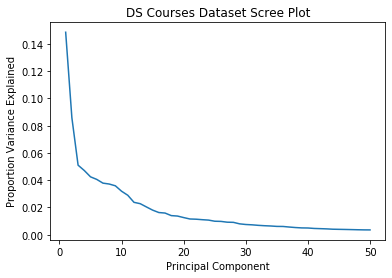

In [67]:
plt.figure()
explained_var = pipe_pca2.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("DS Courses Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

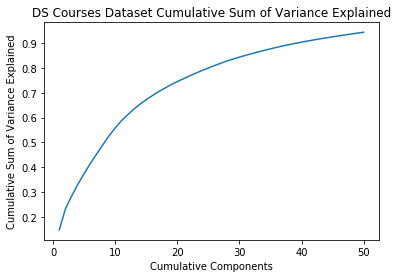

In [68]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("DS Courses Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [69]:
sum(pipe_pca2.stages[-1].explainedVariance[0:24])

0.7896469205739716

In [70]:
sum(pipe_pca2.stages[-1].explainedVariance[0:49])

0.9396768262761406

Your Answer Here:
From the scree plot we can see that around 25 Principal Components explain variance which is greater than 0.01 each. For the remaining principal components above 25 the explained variance is less than 0.01 meaning individually they are not able to explain even 1% each variance in the data so they have very less interpretive value. Also, from the Cumulative Variance plot it is evident that around 25 Principal Components out of 50 explain a total of around 79% variance in the data whereas the remaining 25 Principal components explain only 15% of the variance in the data. So utilizing only the 1st 25 Principal components is beneficial as second half of the components in total explain 15% and 1st half explain 79% of variance. So keeping 25 Principal components is required. But from the explained variance calculated from each Principal component we get only 24 Principal components each of which explain 1% or more variance in the data. In other words, we can say that we have reduced the number of predictors from 50 to 24 to handle the dataset more efficiently wothout making a huge compromise on the explained variance by these Principal Components. The data can be very big at times in real world and reducing the number of predictors which explain the variance is needed to process data faster without leaving important predictors is important. So I would choose 24 Principal Components to be used.

##### Grading Feedback Cell
-1: Your analysis is sound but not based on the total possible number of principal components which is 98.  The question asked about the scree plot you produced above which was based on ALL available principal components.  I would hesitate to base the selected number of principal components solely based on if it explains more than .01 - though this is a valid data point to consider among others.  Should also look at the total variance explained and the shape of the scree plot.